In [1]:
# Grab Data
import yfinance as yf

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
from pypfopt.plotting import plot_weights

In [2]:
# Create a Portfolio
symbols = [
    "AAPL",
    "MSFT",
    "META",
    "AMZN",
    "XOM",
    "UNH",
    "JNJ",
    "V",
    "HD",
    "ABBV",
    "KO",
    "DIS",
    "T",
    "UPS",
    "LMT",
    "CAT",
    "F",
    "MAR",
    "O",
    "HSY",
]

In [3]:
# Get the stock data
portfolio = yf.download(symbols, start="2018-01-01", end="2023-02-28")["Close"]
# SP500 ETF Benchmark
market_prices = yf.download("SPY", start="2018-01-01", end="2023-02-28")["Close"]
market_prices.head()
portfolio.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12312\3981919022.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  portfolio = yf.download(symbols, start="2018-01-01", end="2023-02-28")["Close"]
[*********************100%***********************]  20 of 20 completed
C:\Users\Admin\AppData\Local\Temp\ipykernel_12312\3981919022.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_prices = yf.download("SPY", start="2018-01-01", end="2023-02-28")["Close"]
[*********************100%***********************]  1 of 1 completed


Ticker,AAPL,ABBV,AMZN,CAT,DIS,F,HD,HSY,JNJ,KO,LMT,MAR,META,MSFT,O,T,UNH,UPS,V,XOM
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.426826,70.405571,59.450500,132.230453,106.943245,8.470928,156.706436,94.098297,112.882576,36.016136,261.119019,125.755821,180.430161,79.328514,38.276936,16.451571,197.135849,94.427795,108.740425,60.040207
2018-01-03,40.419785,71.507301,60.209999,132.432526,107.402374,8.537839,157.523178,93.703819,113.960854,35.937046,263.307709,128.294434,183.662399,79.697693,38.175545,16.071657,199.203827,96.519920,109.823013,61.219418
2018-01-04,40.607536,71.099510,60.479500,134.251297,107.354553,8.685043,158.773315,94.358505,113.952759,36.443203,267.824402,127.589272,183.324265,80.399170,37.350758,16.221062,200.068466,97.146049,110.231339,61.304150
2018-01-05,41.069866,72.337212,61.457001,136.373199,106.771049,8.832249,160.431793,94.811768,114.893250,36.435291,270.250916,126.366989,185.830521,81.395950,37.323730,16.280823,203.883514,97.443802,112.871246,61.254723
2018-01-08,40.917309,71.178223,62.343498,139.800186,105.240562,8.798792,160.048477,95.735016,115.039169,36.379932,269.004761,128.190994,187.252716,81.479034,37.371067,16.327774,200.344788,98.627289,113.327087,61.530121


In [4]:
# Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 3003400323072,
 'MSFT': 3895798530048,
 'META': 1884130115584,
 'AMZN': 2290287116288,
 'XOM': 467395313664,
 'UNH': 215690674176,
 'JNJ': 402987515904,
 'V': 658658033664,
 'HD': 371764789248,
 'ABBV': 344836603904,
 'KO': 296350711808,
 'DIS': 209599660032,
 'T': 198423314432,
 'UPS': 71554433024,
 'LMT': 98291097600,
 'CAT': 201619341312,
 'F': 43062083584,
 'MAR': 69939347456,
 'O': 51087237120,
 'HSY': 38316863488}

## Calculate priors

In [5]:
# compute risk adversion coefficient delta
delta = black_litterman.market_implied_risk_aversion(market_prices)

<Axes: xlabel='Ticker', ylabel='Ticker'>

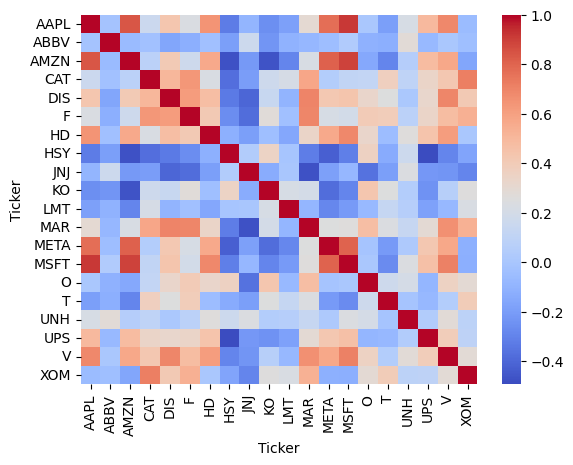

In [6]:
# Clean up historical porfolio coveriance using Ledoit-Wolf shrinkage
cov_matrix = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
# Visualize the Covariant Correlation
sns.heatmap(cov_matrix.corr(), cmap="coolwarm")

In [7]:
# compute prior returns using market capitalization as weights, risk adversion coefficient and covariance matrix
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)
market_prior

Ticker
AAPL    0.191570
ABBV    0.082257
AMZN    0.193748
CAT     0.111392
DIS     0.128774
F       0.130432
HD      0.129964
HSY     0.057966
JNJ     0.066360
KO      0.069383
LMT     0.073262
MAR     0.129007
META    0.222146
MSFT    0.188649
O       0.091165
T       0.071209
UNH     0.107759
UPS     0.109892
V       0.143164
XOM     0.093723
dtype: float64

<Axes: ylabel='Ticker'>

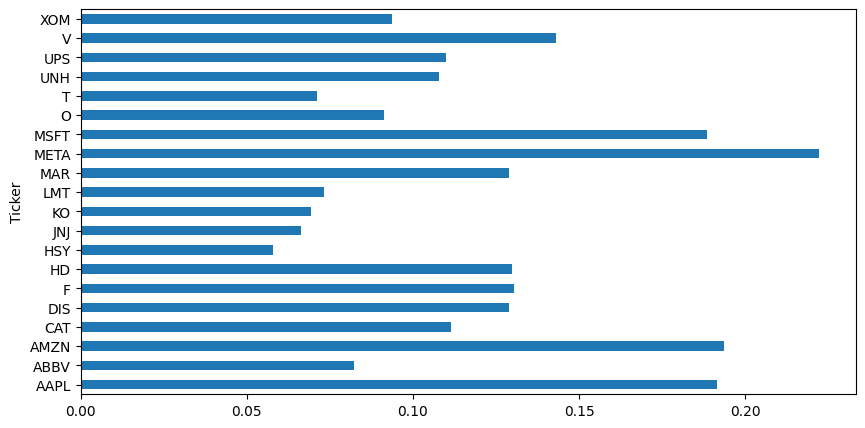

In [8]:
# visualize prior returns
market_prior.plot.barh(figsize=(10, 5))

## Customize uncertainty matrix omega

In [9]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
]
variances = []
for lb, ub in intervals:
    sigma = (ub - lb) / 2
    variances.append(sigma**2)

print(variances)
# compute uncertainty matrix omega of views
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


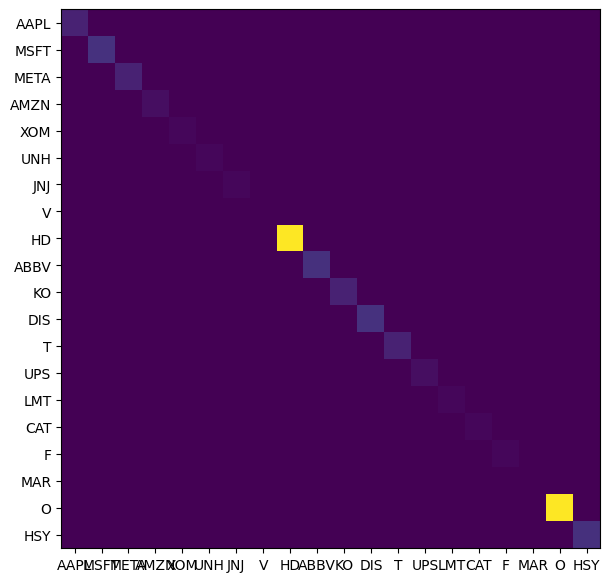

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(symbols)))
ax.set_yticks(np.arange(len(symbols)))

ax.set_xticklabels(symbols)
ax.set_yticklabels(symbols)
plt.show()

## Calculate posterior estimate returns

In [11]:
# absolute views for stocks in portfolio
# relative views and be integrated using vector Q and picking matrix P
# https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views
viewdict = {
    "AAPL": 0.10,
    "MSFT": 0.10,
    "META": 0.05,
    "AMZN": 0.30,
    "XOM": 0.02,
    "UNH": 0.01,
    "JNJ": 0.15,
    "V": 0.09,
    "HD": 0.16,
    "ABBV": 0.07,
    "KO": 0.01,
    "DIS": -0.23,
    "T": 0.16,
    "UPS": 0.10,
    "LMT": -0.09,
    "CAT": 0.30,
    "F": 0.16,
    "MAR": -0.08,
    "O": 0.30,
    "HSY": -0.26,
}
# build black litterman model
bl = BlackLittermanModel(
    cov_matrix,
    pi=market_prior, # pi="market" for default prior returns
    market_caps=mcaps,
    risk_aversion=delta,
    absolute_views=viewdict,
    omega=omega, # omega="idzorek" for default views
)

<Axes: >

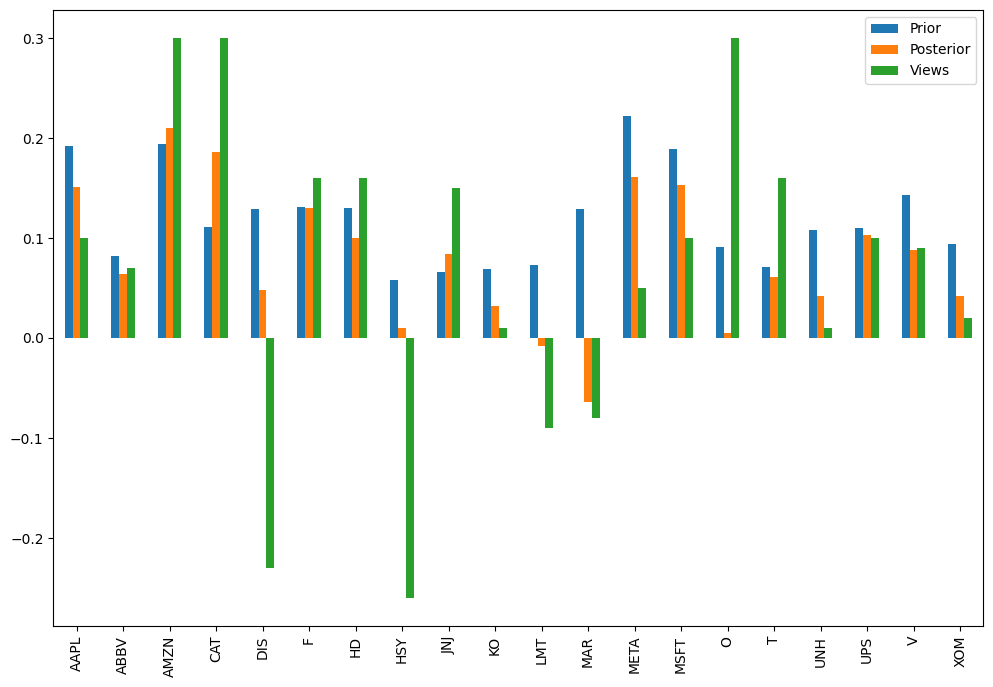

In [12]:
# Posterior estimate of returns
post_ret_bl = bl.bl_returns()
rets_df = pd.DataFrame(
    [market_prior, post_ret_bl, pd.Series(viewdict)],
    index=["Prior", "Posterior", "Views"],
).T
rets_df.plot.bar(figsize=(12, 8))

<Axes: >

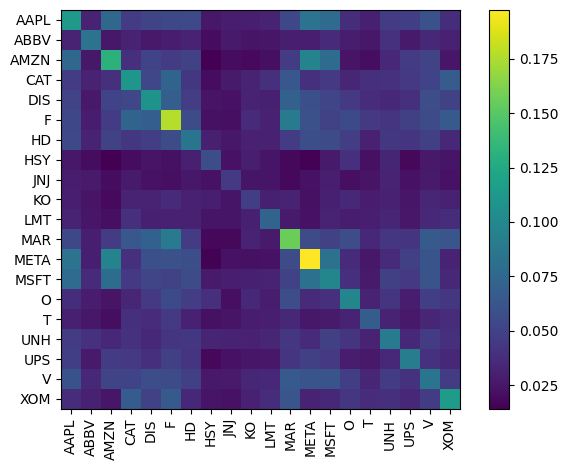

In [13]:
# posterior estimate of covariance
post_cov_bl = bl.bl_cov()
plotting.plot_covariance(post_cov_bl)

## Portfolio allocation

In [14]:
ef = EfficientFrontier(post_ret_bl, post_cov_bl)
# add L2 regularization to increase non-zero weights
ef.add_objective(objective_functions.L2_reg)
# goal is to maximize Sharpe ratio
ef.max_sharpe()
weights = ef.clean_weights()
weights

d:\miniconda\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.0987),
             ('ABBV', 0.03678),
             ('AMZN', 0.15939),
             ('CAT', 0.14676),
             ('DIS', 0.00202),
             ('F', 0.0776),
             ('HD', 0.05756),
             ('HSY', 0.0),
             ('JNJ', 0.06362),
             ('KO', 0.00724),
             ('LMT', 0.0),
             ('MAR', 0.0),
             ('META', 0.0982),
             ('MSFT', 0.10188),
             ('O', 0.0),
             ('T', 0.03406),
             ('UNH', 0.00512),
             ('UPS', 0.06475),
             ('V', 0.0418),
             ('XOM', 0.00451)])

<Axes: >

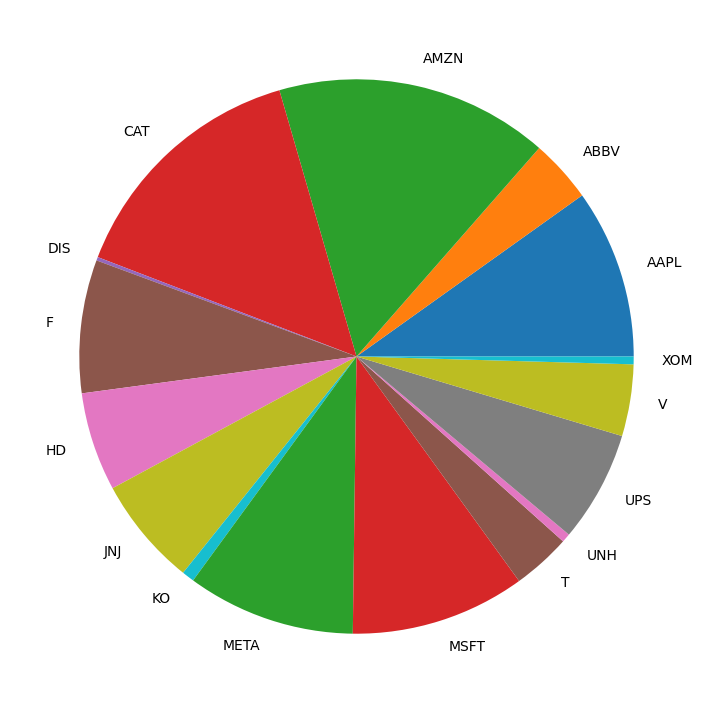

In [15]:
pd.Series(weights).plot.pie(figsize=(9, 9))

Expected annual return: 14.4%
Annual volatility: 23.7%
Sharpe Ratio: 0.61


d:\miniconda\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(np.float64(0.14376682691769926),
 np.float64(0.23657271290058024),
 np.float64(0.6077067179684299))

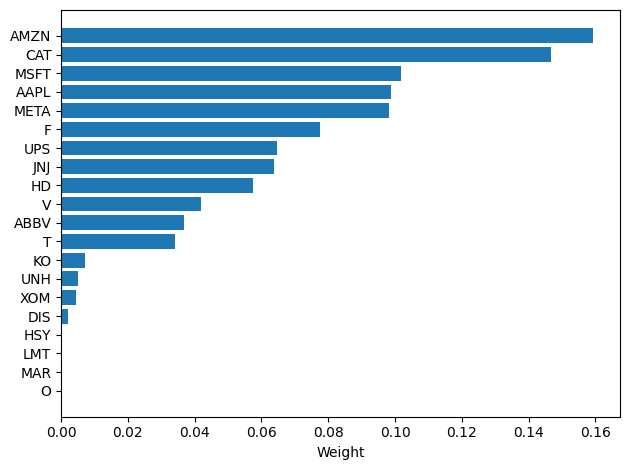

In [16]:
plot_weights(weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0.009)